# Wikimedia dataset analysis and preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load training data
data_train = pd.read_csv("train_tarea_recsys_2019.csv")
data_train["evaluation"] = False
data_train.head()

,user,image_id,timestamp,evaluation
0,1,200502005,1108503300,False
1,1,200504028,1113243060,False
2,1,200504029,1113243060,False
3,1,200504034,1113246480,False
4,1,200504035,1113246600,False


In [3]:
# Load test data
data_test = pd.read_csv("test_tarea_recsys_2019.csv")
data_test["evaluation"] = True
data_test.head()

,user,image_id,timestamp,evaluation
0,1,200602085,1140370560,True
1,6,200510005,1128099960,True
2,11,200604035,1143603900,True
3,12,200805003,1208850300,True
4,13,201011221,1290851640,True


In [4]:
# Append training and test data
data = pd.concat((data_train, data_test))
data

,user,image_id,timestamp,evaluation
0,1,200502005,1108503300,False
1,1,200504028,1113243060,False
2,1,200504029,1113243060,False
3,1,200504034,1113246480,False
4,1,200504035,1113246600,False
...,...,...,...,...
1074,7367,201904195,1555539180,True
1075,7374,201904241,1556141100,True
1076,7378,201904028,1553881560,True
1077,7388,201904241,1556164740,True


## Interactions data

In [5]:
print("Interactions shape", data.shape)

Interactions shape (97612, 4)


There are 96533 rows in the data file, where only possitive feedback is considered. But first, some user-item interactions are repeated, and we'll consider only the last one.

In [6]:
# Sort by timestamp
data = data.sort_values(by="timestamp", ascending=True)

In [7]:
# Keep latest interaction between user-item pairs
data = data.groupby(["user", "image_id"]).tail(1).reset_index(drop=True)

In [8]:
print("Interactions shape", data.shape)

Interactions shape (96991, 4)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96991 entries, 0 to 96990
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user        96991 non-null  int64
 1   image_id    96991 non-null  int64
 2   timestamp   96991 non-null  int64
 3   evaluation  96991 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 2.3 MB


In [10]:
data.head()

,user,image_id,timestamp,evaluation
0,30,200501002,1105490700,False
1,12,200501002,1105521180,False
2,31,200501002,1105568700,False
3,6,200501002,1105646820,False
4,14,200501002,1105738260,False


In [11]:
data.describe()

,user,image_id,timestamp
count,96991.000000,9.699100e+04,9.699100e+04
mean,3466.701178,2.013671e+08,1.391502e+09
std,2047.348209,3.692753e+05,1.165674e+08
min,1.000000,2.005010e+08,1.105491e+09
25%,1706.000000,2.011041e+08,1.302758e+09
50%,3714.000000,2.015020e+08,1.422168e+09
75%,5049.000000,2.017012e+08,1.485015e+09
max,7395.000000,2.019042e+08,1.556348e+09


Sort and reset index.

In [12]:
data = data.sort_values(by="timestamp", ascending=True)
data = data.reset_index(drop=True)
data.head()

,user,image_id,timestamp,evaluation
0,30,200501002,1105490700,False
1,12,200501002,1105521180,False
2,31,200501002,1105568700,False
3,6,200501002,1105646820,False
4,14,200501002,1105738260,False


**How many users and items left?** Some may have been dropped, so let's count again:

In [13]:
print("Users:", data["user"].nunique())
print("Items:", data["image_id"].nunique())

Users: 1079
Items: 9636


**Maximum number of interactions at the same time?** Sometimes this happens

In [14]:
# No idea how (or why)
data.groupby(["timestamp"]).count().max()

user          21
image_id      21
evaluation    21
dtype: int64

**Number of interactions per item?**

In [15]:
items = data.groupby(["image_id"]).count()["user"]
items.describe()

count    9636.000000
mean       10.065484
std         4.368160
min         4.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        34.000000
Name: user, dtype: float64

**Most active items?**

In [16]:
most_active_items = items.sort_values(ascending=False)
most_active_items.head()

image_id
201707149    34
201204203    32
201804142    31
201901175    31
201812099    30
Name: user, dtype: int64

In [17]:
N = 964  # 10%
interactions_by_active_items = most_active_items[:N].sum() / items.sum() * 100
print(f"{interactions_by_active_items:.2f} % of interactions comes from the top {N} most active items")

19.27 % of interactions comes from the top 964 most active items


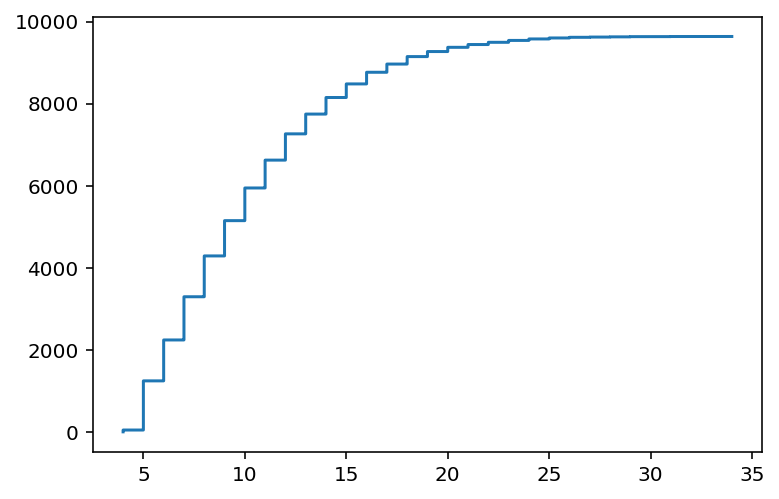

In [18]:
sorted_data = np.sort(most_active_items)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

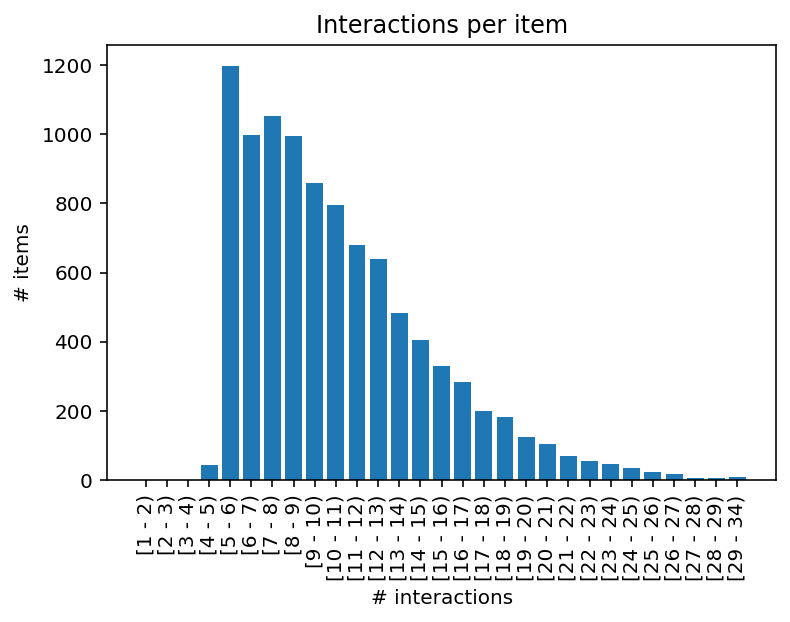

In [19]:
bins = list(range(1, 30)) + [items.max()]

hist, bins = np.histogram(items, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]} - {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per item")
plt.xlabel("# interactions")
plt.ylabel("# items")
plt.show()

**Number of interactions per user?**

In [20]:
users = data.groupby(["user"]).count()["image_id"]
users.describe()

count    1079.000000
mean       89.889713
std       259.070384
min         4.000000
25%         8.000000
50%        16.000000
75%        53.000000
max      3544.000000
Name: image_id, dtype: float64

**Most active users?**

In [21]:
most_active_users = users.sort_values(ascending=False)
most_active_users.head()

user
2524    3544
4605    3006
2133    2609
5907    2252
5607    1971
Name: image_id, dtype: int64

In [22]:
N = 108  # 10%
interactions_by_active_users = most_active_users[:N].sum() / users.sum() * 100
print(f"{interactions_by_active_users:.2f} % of interactions comes from the top {N} most active users")

69.87 % of interactions comes from the top 108 most active users


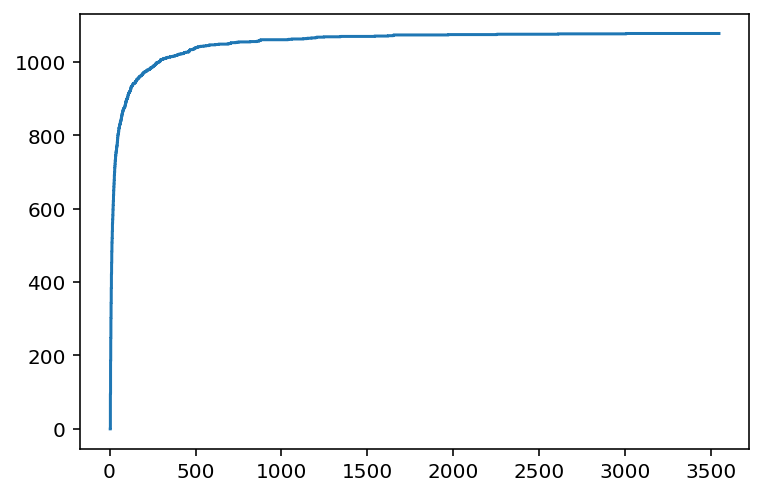

In [23]:
sorted_data = np.sort(most_active_users)
plt.step(sorted_data, np.arange(sorted_data.size))
plt.show()

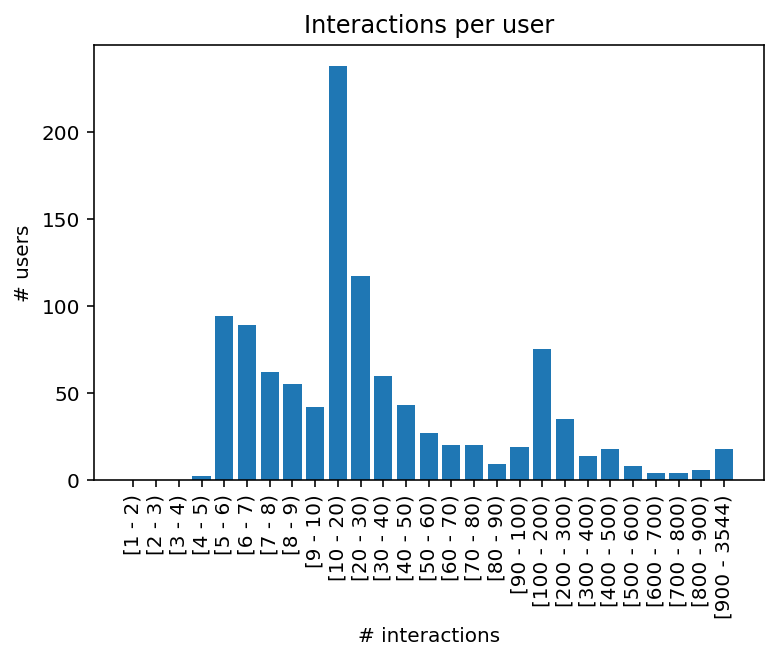

In [24]:
bins = (
    list(range(1, 10))
    + [10*i for i in range(1, 10)]
    + [100*i for i in range(1, 10)]
    + [users.max()]
)

hist, bins = np.histogram(users, bins)
x_axis = np.arange(0, len(hist))
plt.bar(x_axis, hist)
bin_names = [f"[{bins[i]} - {bins[i+1]})" for i in range(len(hist))]
plt.xticks(x_axis, bin_names, rotation=90)

# Title and labels
plt.title("Interactions per user")
plt.xlabel("# interactions")
plt.ylabel("# users")
plt.show()

## Output

In [25]:
n_users = data["user"].nunique()
n_items = data["image_id"].nunique()
n_items_gt = 32958
print(f"Unique users: {n_users}")
print(f"Unique items: {n_items_gt}")
print(f"Unique items 'interacted': {n_items}")
print(f"Interactions per user: {users.mean()} +/- {users.std()}")
actual_mean = items.sum() / n_items_gt
actual_std = np.sqrt(np.mean(np.abs(items - actual_mean)**2))
print(f"Interactions per item: {actual_mean} +/- {actual_std}") 
print(f"Interactions per 'interacted' item: {items.mean()} +/- {items.std()}")
possible_interactions = n_users * n_items_gt
print(f"Possible interactions: {possible_interactions}")
print(f"Sparsity: {100 * len(data) / possible_interactions:2f}%")

Unique users: 1079
Unique items: 32958
Unique items 'interacted': 9636
Interactions per user: 89.88971269694161 +/- 259.0703836927123
Interactions per item: 2.9428666788033255 +/- 8.355268369544314
Interactions per 'interacted' item: 10.065483603154837 +/- 4.368159547869315
Possible interactions: 35561682
Sparsity: 0.272740%


In [26]:
data

,user,image_id,timestamp,evaluation
0,30,200501002,1105490700,False
1,12,200501002,1105521180,False
2,31,200501002,1105568700,False
3,6,200501002,1105646820,False
4,14,200501002,1105738260,False
...,...,...,...,...
96986,2738,201904242,1556319720,False
96987,2738,201904241,1556319780,True
96988,7298,201904241,1556338260,False
96989,7298,201904242,1556338380,True


In [27]:
data = data.rename(columns={
    "user": "user_id",
    "image_id": "item_id",
})
data = data[["user_id", "item_id", "timestamp", "evaluation"]]
data = data.sort_values("timestamp")
data = data.reset_index(drop=True)

In [28]:
data.to_csv("wikimedia.csv", index=False)

In [29]:
data

,user_id,item_id,timestamp,evaluation
0,30,200501002,1105490700,False
1,12,200501002,1105521180,False
2,31,200501002,1105568700,False
3,6,200501002,1105646820,False
4,14,200501002,1105738260,False
...,...,...,...,...
96986,2738,201904242,1556319720,False
96987,2738,201904241,1556319780,True
96988,7298,201904241,1556338260,False
96989,7298,201904242,1556338380,True
